# Đồ án cuối kỳ: Dự báo thời tiết
<br>
NGƯỜI THỰC HIỆN: TRẦN XUÂN LỘC - 18127131<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;THÁI HOÀNG HUY - 18127109<br>
LỚP: 18KHMT<br>
Giáo viên hướng dẫn: TRẦN TRUNG KIÊN


## Môi trường code

- Ở đây, ta cần tải một số thư viện cần thiết và yêu cầu thư viện sikit-learn phiên bản >= 0.24 do đó ta thực hiện kiểm tra phiên bản hiện tại.

In [1]:
# kiểm tra phiên bản scikit-learn hiện tại có phù hợp không.
import sklearn
sklearn.__version__

'0.24.2'

- Tiếp theo ta cũng thực hiện cài thêm thư viện imbalanced-learn cho bài toán tái tạo mẫu trong đồ án.

In [2]:
!pip install -U imbalanced-learn

- Kiểm tra môi trường chạy code.

In [3]:
import sys
sys.executable

'C:\\Users\\USER\\anaconda3\\envs\\min_ds-env\\python.exe'

---

## Import

**Lưu ý:** Môi trường và thư viện sử dụng không tương thích với các phiên bản python từ 3.8 trở lên. Chính vì vậy cần kiểm tra phiên bản python bằng câu lệnh 'python --version' trước khi chạy code bên dưới. Nếu phiêu bản python của mọi người không thoả mãn yêu cầu trên có thể cải đặt môi trường ảo cho Anaconda.[(Xem thêm)](https://uoa-eresearch.github.io/eresearch-cookbook/recipe/2014/11/20/conda/)

In [4]:
from calendar import monthrange
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns 
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import set_config
from sklearn.utils import class_weight
from sklearn.svm import SVC
set_config(display='diagram')
from imblearn.over_sampling import ADASYN , SMOTE
from scipy import stats

## Khám phá dữ liệu

- Thực hiện đọc dữ liệu từ các tệp dữ liệu thu thập từ các quốc gia khác nhau và gom lại thành 1 dataframe duy nhất là *data_df*, gom các dataframe khác nhau thành 1 dataframe duy nhất bằng phương thức *concat* của pandas.

In [5]:
#gộp dữ liệu từ các file csv đã thu thập
folder_path = 'data//'
countries = ["Canada","Sweden", "South Korea", "Peru", "Greenland", "Argentina", "Ethiopia", "Mexico", "Egypt", "Indonesia", "Japan", "China", "Austria","United Kingdom","Nigeria","VietNam","South Africa","United States", "Poland","Russia","Ireland"]
data_df = pd.DataFrame()
for country_file in countries:
    tmp_df = pd.read_csv(folder_path+country_file+'.csv')
    data_df = pd.concat([data_df, tmp_df]) 
data_df.head()

,message,lat,lng,time,summary,icon,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,Country
0,success,56.130366,-106.346771,1577865600,Foggy,fog,16.47,16.47,7.47,0.67,989.4,1.86,1.95,24,0.97,0,1.267,395.1,Canada
1,success,56.130366,-106.346771,1577880000,Overcast,cloudy,17.23,17.23,8.88,0.69,991.1,2.32,4.87,340,0.94,0,6.088,396.2,Canada
2,success,56.130366,-106.346771,1577898000,Overcast,cloudy,18.97,18.97,12.73,0.76,992.1,1.41,1.95,296,1.00,0,5.610,403.0,Canada
3,success,56.130366,-106.346771,1577952000,Foggy,fog,14.77,14.77,2.97,0.59,997.7,2.74,5.13,198,0.97,0,1.076,449.4,Canada
4,success,56.130366,-106.346771,1577966400,Overcast,cloudy,13.16,7.72,4.72,0.68,998.8,3.15,8.85,284,0.98,0,3.685,441.7,Canada


### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?
- Dữ liệu chúng ta thu thập được bao gồm 9828 mẫu và 19 cột khác nhau.

In [6]:
data_df.shape

(9828, 19)

### Dữ liệu có các dòng bị lặp không?
- Tuyệt vời... không có dòng nào bị lặp cả.

In [7]:
data_df.duplicated().sum()

0

### Mỗi cột có ý nghĩa gì?

- message: thông báo trước mỗi dòng dữ liệu khi kéo thành công dữ liệu thời tiết từ API.
- lat: viết tắt cho latitude có nghĩa là vĩ độ và lng viết tắt cho longitude có nghĩa là kinh độ. lat và lng được dùng để xác định vị trí của nơi lấy thông số thời tiết từ API trong đó vĩ độ được xác định xiên góc theo hướng bắc-nam và kinh độ được tính xiên góc theo hướng đông-tây.
- time: thời gian truy vấn dữ liệu thời tiết tại vị trí đã xác định.
- summary: Sự giải thích của các chuyên gia từ dữ liệu thời tiết.
- icon: Biểu tượng thời tiết của dữ liệu.
- temperature: Nhiệt độ không khí được đo theo độ F.
- apparentTemperature: Nhiệt độ thực tế cảm nhận được được đo theo độ F.
- dew point: Theo wikipedia là "Điểm sương hay còn gọi là điểm ngưng sương, nhiệt độ hóa sương của một khối không khí, ở áp suất khí quyển cố định, là nhiệt độ mà ở đó thành phần hơi nước trong khối không khí ngưng đọng thành nước lỏng. Nói cách khác, điểm sương là nhiệt độ mà độ ẩm tương đối của khối không khí đạt đến 100%." và được đo theo độ F.
- humidity: độ ẩm không khí có giá trị từ 0 đến 1.
- pressure: hay còn được gọi là áp suất khí quyển. Theo wikipedia, "áp suất khí quyển, đôi khi còn được gọi là áp suất không khí, là độ lớn của áp lực trong bầu khí quyển Trái Đất (hay của một hành tinh khác, ngôi sao khác) trên một đơn vị diện tích. Trong hầu hết các trường hợp, áp suất khí quyển gần tương đương với áp suất thủy tĩnh do trọng lượng của không khí ở trên điểm đo. Nếu độ cao tăng, khối lượng khí quyển giảm xuống ít hơn, do đó áp suất khí quyển giảm với độ cao ngày càng tăng." Áp suất khí quyển trong trường hợp này được đo bằng đơn vị millibars.
- windSpeed: Biểu diễn tốc độ gió và được đo bằng đơn vị dậm trên giờ và một dậm bằng 1.609 mét. 
- windGust: Khác với tốc độ gió, gió giật là tốc độ gió tăng đột ngột và được tính bằng đơn vị dậm trên giờ.
- windBearing: Để chỉ hướng gió đến và được đo theo độ.
- cloudCover: Phần trăm bầu trời được che phủ bởi mây và có giá trị từ 0 đến 1.	- uvIndex: Đo độ mạnh yếu của tia cực tím chiếu xuống một khu vực xác định.
- visibility: Theo wikipedia, "tầm nhìn xa là khoảng cách xa nhất mà con người có thể quan sát bằng mắt các vật thể (tiêu điểm) trên nền trời, tùy thuộc vào độ trong suốt của khí quyển do ảnh hưởng bởi nhiều yếu tố như lượng mây, mù, sương mù, mưa và các hiện tượng khí quyển khác." Yếu tố tầm nhìn trong trường hợp này được đo bằng tầm nhìn trung bình theo dặm, giới hạn ở 10 dặm.
- ozone: Mật độ cột của tổng ôzôn trong khí quyển tại thời điểm nhất định tính bằng đơn vị Dobson.
- Country: Tên nước được lấy dữ liệu thời tiết tương ứng với giá trị lat và lng.

#### Số lượng mẫu của từng quốc gia

- Sử dụng phương thức *value_counts* để xem số lượng mẫu đóng góp của từng quốc gia.


In [8]:
data_df.Country.value_counts()

Indonesia         468
Greenland         468
Peru              468
South Korea       468
South Africa      468
Austria           468
Sweden            468
United Kingdom    468
Ireland           468
Japan             468
China             468
Nigeria           468
Poland            468
Canada            468
Egypt             468
VietNam           468
Mexico            468
Argentina         468
United States     468
Ethiopia          468
Russia            468
Name: Country, dtype: int64

#### Cột dữ liệu output có kiểu dữ liệu gì?

In [9]:
data_df.icon.dtype

dtype('O')

- Cột dữ liệu output icon có dạng Object.

#### Số lượng giá trị bị thiếu của cột output?

In [10]:
data_df.icon.isna().sum()

0

- Điều này chứng tỏ dữ liệu output của chúng ta không bị thiếu.

#### Phân bố dữ liệu của từng loại thời tiết dựa trên giải thích của chuyên gia (summary) như thế nào?

- Ta sử dụng phương thức *value_count* và đối số *normalize=True* sau đó nhân với 100 để xem phần trăm đóng góp của từng loại thời tiết dựa trên phân tích của chuyên gia trên cột **summary**

In [11]:
data_df.summary.value_counts(normalize=True)*100

Clear                                        29.497354
Overcast                                     16.615792
Mostly Cloudy                                16.259666
Partly Cloudy                                14.122914
Foggy                                         3.347578
Humid and Overcast                            3.164428
Humid and Mostly Cloudy                       2.859178
Possible Light Rain                           2.726903
Possible Light Rain and Humid                 1.882377
Rain                                          1.739927
Rain and Humid                                1.363451
Humid and Partly Cloudy                       1.353276
Possible Drizzle                              1.302401
Humid                                         0.814001
Possible Drizzle and Humid                    0.356125
Windy and Overcast                            0.264550
Light Rain                                    0.264550
Windy and Mostly Cloudy                       0.223850
Snow      

- Sau đó ta thực hiện trực quan hóa dưới dạng biểu đồ cột (bar chart) bằng phương thức *plot* truyền vào đối số *kind='bar'*.

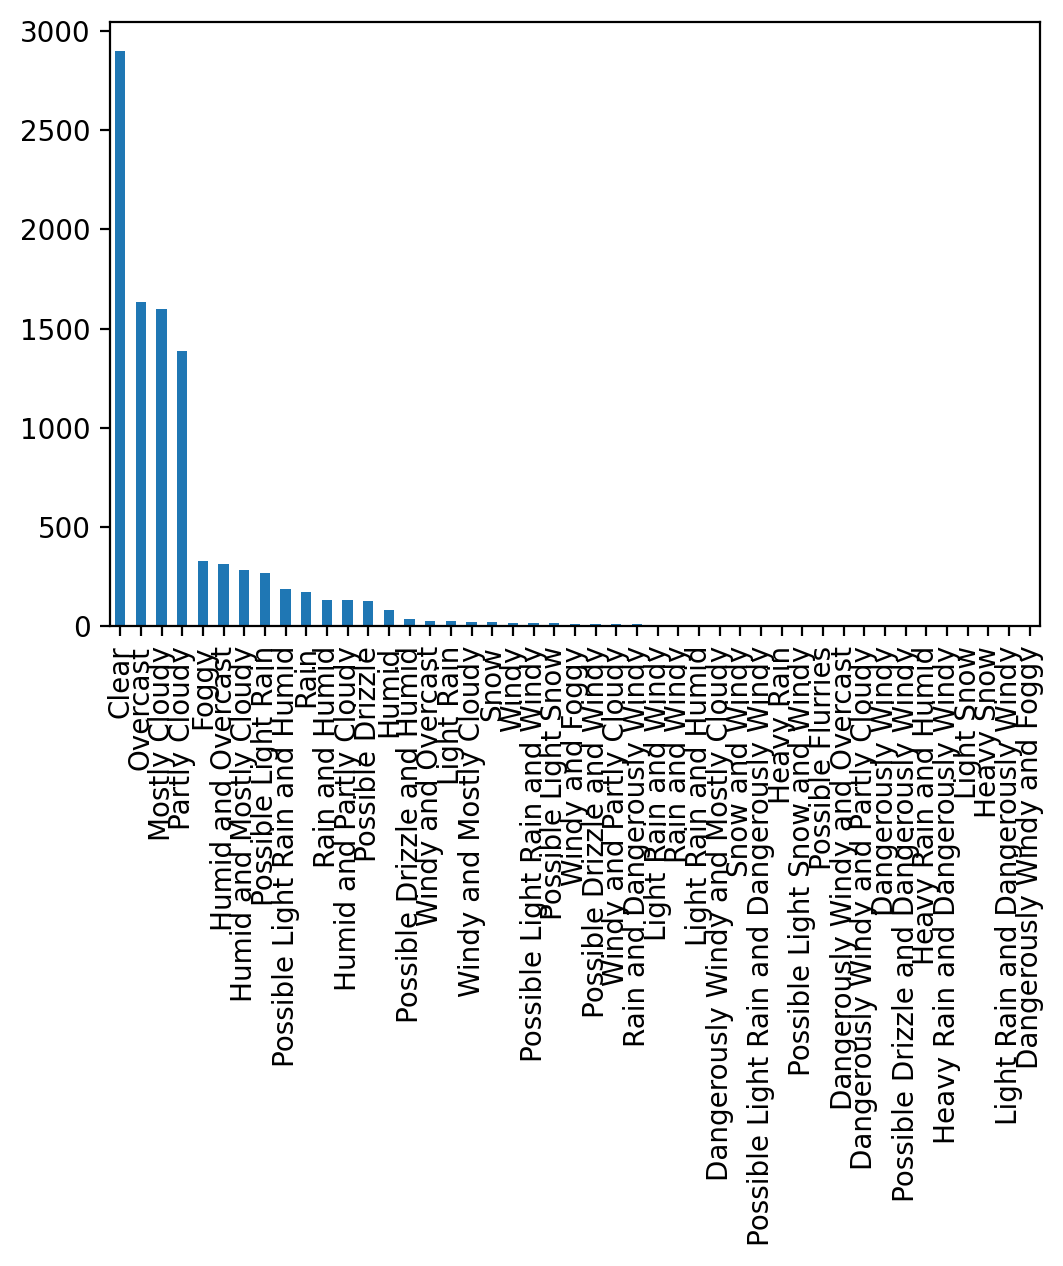

In [12]:
plt.rcParams['figure.dpi'] = 200
data_df.summary.value_counts().plot(kind='bar');

**Nhận xét:**
* Dễ dàng thấy, có hơn 2/3 các cột dữ liệu có rất ít mẫu do đó ta sẽ không chọn cột **summary** làm cột dữ liệu output cho mô hình và thực hiện bỏ đi cột này ở bước tiếp theo.
* Lí do tiếp theo để không chọn cột này làm phân lớp chính bởi vì dữ liệu có rất nhiều phân lớp (do có sự giải thích đánh giá của các chuyên gia) sẽ gây ra tình trạng dữ liệu thưa và ảnh hưởng rất lớn đến độ chính xác của mô hình.
* Dữ liệu bị trùng lắp rất nhiều ví dụ như Snow and Windy, Possible Light Snow and Windy. Ta thấy rất khó để tách biệt các tính chất trên thành các tập riêng biệt và nếu bỏ đi sẽ gây mất mát các thông tin quan trọng về thời tiết bất thường.

#### Phân bố dữ liệu của từng loại thời tiết dựa biểu tượng đặc trưng (icon) như thế nào?

- Sau đó, ta thực hiện những phân tích tương tự như trên đối với cột **icon** do cột **summary** dựa trên phân tích chuyên gia nên những phân tích ở mức quá chi tiết nên khó có thể trùng những phân tích trên với từng mẫu khác nhau. Do đó ta chọn cột **icon** làm cột dữ liệu output.

In [13]:
data_df.icon.value_counts(normalize=True)*100

partly-cloudy-day      21.367521
cloudy                 19.780220
clear-day              18.416768
partly-cloudy-night    13.227513
clear-night            11.894587
rain                   10.368335
fog                     3.347578
wind                    1.078551
snow                    0.518926
Name: icon, dtype: float64

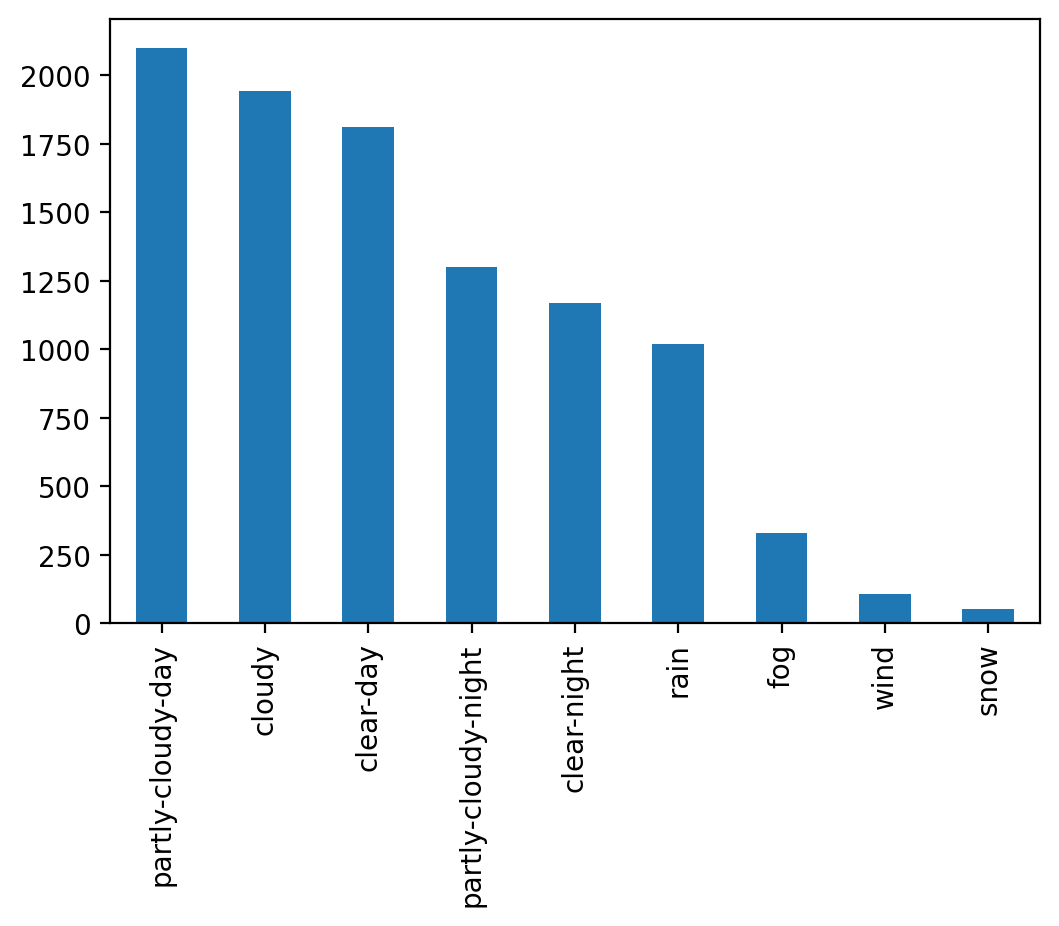

In [14]:
plt.rcParams['figure.dpi'] = 200
data_df.icon.value_counts().plot(kind='bar');

**Nhận xét:**
* Dữ liệu bị mất cân bằng nhưng không vẫn dễ chịu hơn ở cột summary và cho người khác cảm giác là sẽ làm gì được với dữ liệu này.
* Dữ liệu có ít phân lớp hơn nhiều so với cột summary.
* Có thể thấy các phân lớp ở đây hoàn toàn tách biệt nhau về tính chất và không có sự trùng lắp nên chúng ta có thể dễ dàng xử lý hơn.

## Đặt câu hỏi cho dữ liệu

Dựa vào các số liệu thời tiết hằng ngày như nhiệt độ, độ ẩm, tốc độ gió,... để dự đoán tình trạng thời tiết có thể xảy ra trong vài giờ tới, với:
* Dự liệu đầu vào: Là các số liệu thời tiết như nhiệt độ, độ ẩm, tốc độ gió,...
* Dữ liệu đầu ra hay là nhãn sẽ dựa trên cột "icon". Việc lựa chọn cột "icon" thay vì cột "summary" vì do cột "summary" ngoài phản ảnh thời tiết hiện tại còn có thêm đánh giá từ các chuyên gia khí hậu nên khi áp dụng vào mô hình sẽ gây ra tình trạng dữ liệu thưa (do quá nhiều phân lớp).

Mô hình này sẽ cố gắng tập trung dự đoán chính xác các yếu tố thời tiết bất thường như mưa, tuyết, gió, sương để giúp cho người dùng có được sự chuẩn bị thích hợp trong các dạng thời tiết này.

## Đặt vấn đề

Câu hỏi cho dữ liệu ở trên tập trung vào việc phân lớp đúng cho các trường hợp thời tiết bất thường như mưa, gió, tuyết, sương nhưng dữ liệu hiện tại lại không đáp ứng đủ điều kiện để phân lớp do dữ liệu bị mất cân bằng (dữ liệu đa phần thuộc trường hợp thời tiết bình thường như clear hay cloudy). Chính vì điều này sẽ ảnh hưởng rất lớn đến việc xây dựng bộ phân lớp do có thể bộ phân lớp sẽ chịu ảnh hưởng từ các mẫu phổ biến và dù tỉ lệ chính xác có cao nhưng sẽ cho kết quả không tốt trong việc dự đoán các mẫu thiểu số.

Đề xuất phương pháp:
* Tăng mẫu huấn luyện: Tìm thêm các mẫu huấn luyện thiểu số để làm giàu tập dữ liệu.
* Tái tạo mẫu: Phát sinh ra các mẫu mới từ mẫu gốc.
* Sự nhạy cảm về chi phí (Cost Sensitivity): Do dữ liệu bị mất cân bằng nên việc cập nhật trọng số không thể giả sử các mẫu là như vậy. Ở phương pháp này việc cập nhật trọng số sẽ được phụ số lượng mẫu của từng phân lớp (số lượng càng nhỏ trọng số càng cao) để cân bằng bộ phân lớp giữa các mẫu.

Các phương pháp này sẽ được trình bày không theo thứ tự liên tiếp mà nằm rải rác giữa các phần trong phần báo cáo bên dưới, cụ thể là:
* Tăng mẫu huấn luyện nằm ở mục Bổ sung dữ liệu.
* Tái tạo mẫu nằm ở mục Tiền xử lí (trên tập dữ liệu huấn luyện).
* Sự nhảy cảm về chi phí nằm ở mục Mô hình Support Vector Classification.

## Bổ sung dữ liệu

### Định nghĩa hàm thu thập dữ liệu mới và dữ liệu bị thiếu ở các nhóm 

- Ta có thể thấy dữ liệu ở các cột **rain, fog, wind, snow** bị thiếu rất nhiều dữ liệu nên ở bước này ta thực hiện thu thập thêm dữ liệu ở một số nước có kiểu khí hậu đó phổ biến.

- Hàm **get_data2** nhận các đối số tương tự như hàm **get_data** nhưng bỏ đi 2 biến *start và end* do ở hàm này ta thực hiện thu thập dữ liệu trong 1 ngày bắt đâu từ 12h hôm trước tới 12h của ngày hôm sau, dữ liệu phụ thuộc rất nhiều vào kiểu thời tiết nên ta truyền vào biến *months* để nhập vào các tháng có kiểu thời tiết phổ biến đó.

In [15]:
def request_data(lat,lng,start,end,key):
    url = "https://api.ambeedata.com/weather/history/by-lat-lng"
    querystring = {"lat":lat,"lng":lng,"from":start,"to":end}
    headers = {
    'x-api-key': key,
    'Content-type': "application/json"
    }
    response = requests.request("GET", url, headers=headers, params=querystring)
    
    if response.status_code != 200 :
        return "error"
    
    return response.text

In [16]:
def get_data2(months, lat, lng, key):
    list_request = []
    for i in months:
        date01 = datetime.strptime("2020-%02d-01 12:00:00"%i, '%Y-%m-%d %H:%M:%S')
        date02 = datetime.strptime("2020-%02d-02 12:00:00"%i, '%Y-%m-%d %H:%M:%S')
        error = False
        for j in range(20):
            list_request.append(request_data(lat,lng,date01.strftime('%Y-%m-%d %H:%M:%S'), 
                                             date02.strftime('%Y-%m-%d %H:%M:%S'),key))
            if list_request[-1] == 'error':
                error = True
                break
            date01 = date01 + timedelta(days = 1)
            date02 = date02 + timedelta(days = 1)
        if error:
            break
            
    return list_request

Việc thu thập dữ liệu thiểu số được diễn ra ở nhiều nước như Moscow, Niseko, Rainier, Wellington, Aomori City, Sapporo, Newfoundland, Montana ở các thời điểm khác nhau do mỗi nước có một thời điểm tuyết rơi, mưa, có sương hay có gió khác nhau. Việc thu nhập dữ liệu hiếm này sẽ phụ thuộc vào việc tìm hiểu đặc điểm thời tiết của từng vị trí ở các thời điểm khác nhau trong năm. Chính vì vậy mà không thể viết một hàm cụ thể cho quá trình bổ sung dữ liệu này ở đây. Hàm get_data_2 ở trên chỉ mang tính chất tương đối. Và do các dữ liệu thuộc các lớp partly-cloudy-day, partly-cloudy-night, cloudy, clear-day và clear-night đã quá dư thừa nên trong qua trình thu thập dữ liệu sẽ được loại bỏ ra chỉ giữ lại các mẫu thiểu số.

In [17]:
#tổng hợp các mẫu thu thập được từ trước
#chỉ giữ lại các mẫu thiểu số như fog, snow, rain và wind từ các mẫu dữ liệu trên
c_add = ['Moscow', "Niseko", "Rainier","Wellington","Aomori City","Montana","Newfoundland"]
#p_add = [["55.755825","37.617298"], ["42.804705","140.687493"], [" 46.879967","-121.726906"]]
#m_add = [[11, 12],[1, 2], [11, 12]]
new_data=pd.DataFrame()
for i in c_add:
    df = pd.read_csv(folder_path+i+".csv")  
    tmp = df[(df.icon=="fog")|(df.icon=="snow")|(df.icon=="rain")|(df.icon=="wind")]
    new_data = pd.concat([new_data, tmp])
new_data.to_csv(folder_path+"rare.csv",index=False)

### Khám phá dữ liệu bổ sung

In [18]:
new_data = pd.read_csv(folder_path+"rare.csv") 

#### Kích thước

In [19]:
new_data.shape

(594, 19)

#### Trực quan hoá dữ liệu

Xem tụi mình có gì trong tập dữ liệu mới vừa tìm được.

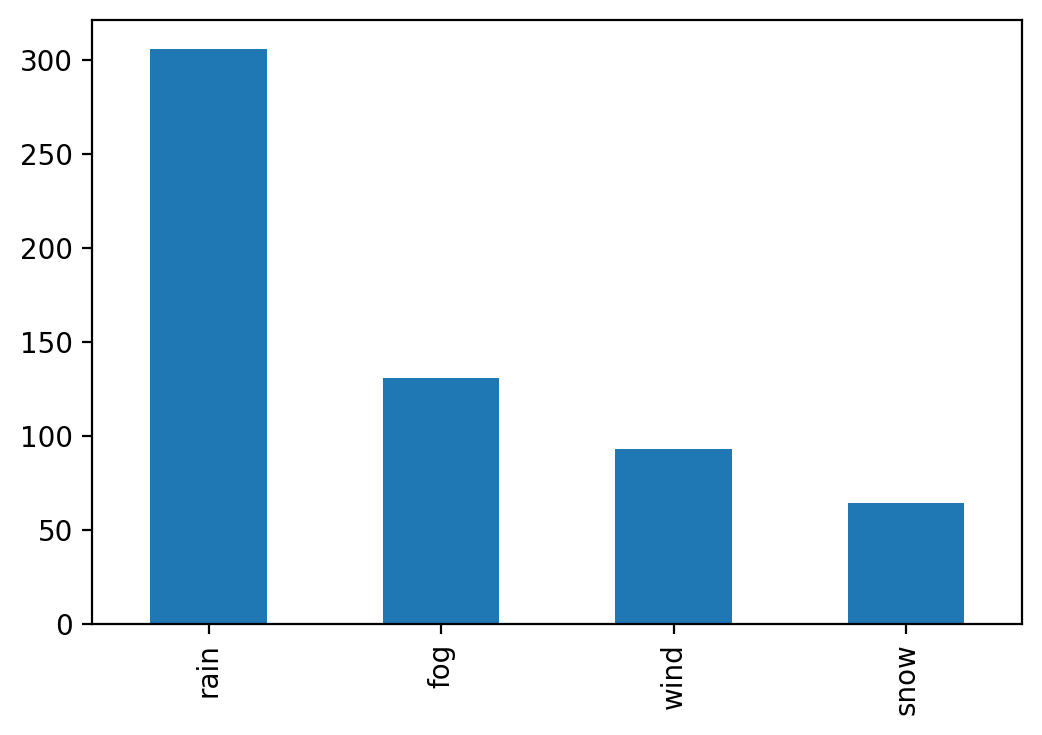

In [20]:
plt.rcParams['figure.dpi'] = 200
new_data.icon.value_counts().plot(kind='bar');

### Thêm dữ liệu mới vào dataframe có sẵn

- Ta thêm dữ liệu mới vào *data_df* bằng phương pháp *concat* đã mô tả ở trên.

In [21]:
data_df = pd.concat([data_df,new_data])
data_df.head()

,message,lat,lng,time,summary,icon,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,Country
0,success,56.130366,-106.346771,1577865600,Foggy,fog,16.47,16.47,7.47,0.67,989.4,1.86,1.95,24,0.97,0,1.267,395.1,Canada
1,success,56.130366,-106.346771,1577880000,Overcast,cloudy,17.23,17.23,8.88,0.69,991.1,2.32,4.87,340,0.94,0,6.088,396.2,Canada
2,success,56.130366,-106.346771,1577898000,Overcast,cloudy,18.97,18.97,12.73,0.76,992.1,1.41,1.95,296,1.00,0,5.610,403.0,Canada
3,success,56.130366,-106.346771,1577952000,Foggy,fog,14.77,14.77,2.97,0.59,997.7,2.74,5.13,198,0.97,0,1.076,449.4,Canada
4,success,56.130366,-106.346771,1577966400,Overcast,cloudy,13.16,7.72,4.72,0.68,998.8,3.15,8.85,284,0.98,0,3.685,441.7,Canada


In [22]:
data_df.shape

(10422, 19)

**Nhận xét:**

Dù nhóm đã cố gắng xem xét dự báo thời tiết của các nước vào những ngày thời tiết bất thường trong năm nhưng kết quả thu được là không cao (cụ thể chỉ được thêm 594 mẫu thiểu số). Việc thu thập những liệu bất thường này diễn ra trong nhiều ngày và tất cả các key API đều quá lượt truy cập, do đó có thể thấy phương pháp thu thập dữ liệu thêm này không phát huy hiệu quả tối đa.

## Tiền xử lí và Khám phá dữ liệu trên tập huấn luyện

#### Chuẩn hóa cột dữ liệu phân lớp (icon)

Đối với nhãn dữ liệu icon bao gồm 5 lớp: partly-cloudy-day, cloudy, clear-day, clear-night, rain, fog, wind, snow. Trong đó ta thấy việc phân biệt giữa partly-cloudy-day và partly-cloudy-night; clear-day và clear-night đem lại hiệu quả không cao do phụ thuộc vào yếu tố thời gian. Chính vì vậy ta sẽ gộp partly-cloudy-day và partly-cloudy-night thành partly-cloudy; clear-day và clear-night thành clear.

In [23]:
def change(a):
    if a =="clear-day" or a == "clear-night":
        return "clear"
    elif a == "partly-cloudy-night" or a =="partly-cloudy-day":
        return "partly-cloudy"
    return a

- Ta thực hiện mã hóa các nhãn của cột *icon* bằng **LabelEncoder()** của scikit-learn. **X** lưu trữ dữ liệu của dataframe trừ cột *icon*, **y** lưu trữ nhãn của cột *icon* đã qua quá trình encoder từ class **LabelEncoder()**

In [24]:
y = data_df["icon"]
y = y.apply(change)
data_df["icon"] = y
enc = LabelEncoder()
y_enc = enc.fit_transform(y)
X = data_df.drop("icon",axis=1)

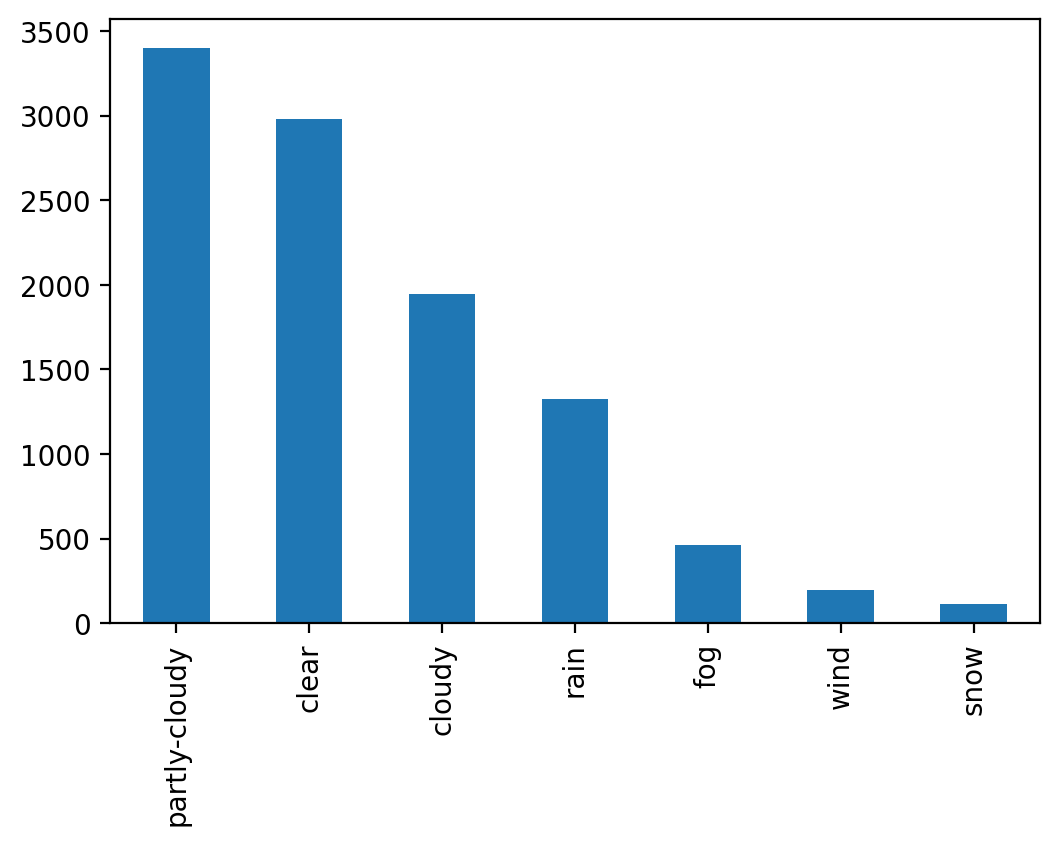

In [25]:
# trực quan hoá dữ liệu
plt.rcParams['figure.dpi'] = 200
y.value_counts().plot(kind='bar');

**Nhận xét:** 

Ta thấy được số lượng dữ liệu phân bố không đồng đều. Chính vì vậy việc phân tách dữ liệu thông thường (phân tách ngẫu nhiên theo tỉ lệ cho trước) có nguy cơ gây ra tình trạng tập huấn luyện chỉ chứa các mẫu có phân lớp phổ biến và các phân lớp thiểu số như snow, wind sẽ không được học. Từ đó sẽ gây kết quả không tốt trên tập kiểm tra.

**Hướng giải quyết:**

* Dùng các thuật toán tái tạo mẫu trên tập huấn luyện để giúp cân bằng dữ liệu.

* Dùng hàm phân tách dữ liệu như thông thường (train_test_split) nhưng thêm tham số stratify - để đảm bảo cho việc phân tầng dữ liệu (chia đều các dòng dữ liệu từ các lớp khác nhau cho cả hai tập huấn luyện và kiểm tra). Tỉ lệ giữa các tập huấn luyện, validation và tập kiểm tra là 60:20:20.

In [26]:
# Tách tập huấn luyện và tập validation, tập kiểm tra theo tỉ lệ 60%:20%:20% hay 3:1:1

x_train, x_val, y_train, y_val = train_test_split(X, y_enc, stratify=y_enc,
                                                  test_size=0.2, train_size=0.8,
                                                  random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,stratify=y_train,
                                                    test_size = 0.25, train_size =0.75,
                                                    random_state=0)

In [27]:
print("Training data size:", x_train.shape, "Truth lable size:", y_train.shape)

Training data size: (6252, 18) Truth lable size: (6252,)


In [28]:
print("Validating data size:", x_val.shape, "Truth lable size:", y_val.shape)

Validating data size: (2085, 18) Truth lable size: (2085,)


In [29]:
print("Testing data size:", x_test.shape, "Truth lable size:", y_test.shape)

Testing data size: (2085, 18) Truth lable size: (2085,)


- Cuối cùng ta trực quan hóa dữ liệu để xem số lượng mẫu của từng tập sau khi tách thành công.

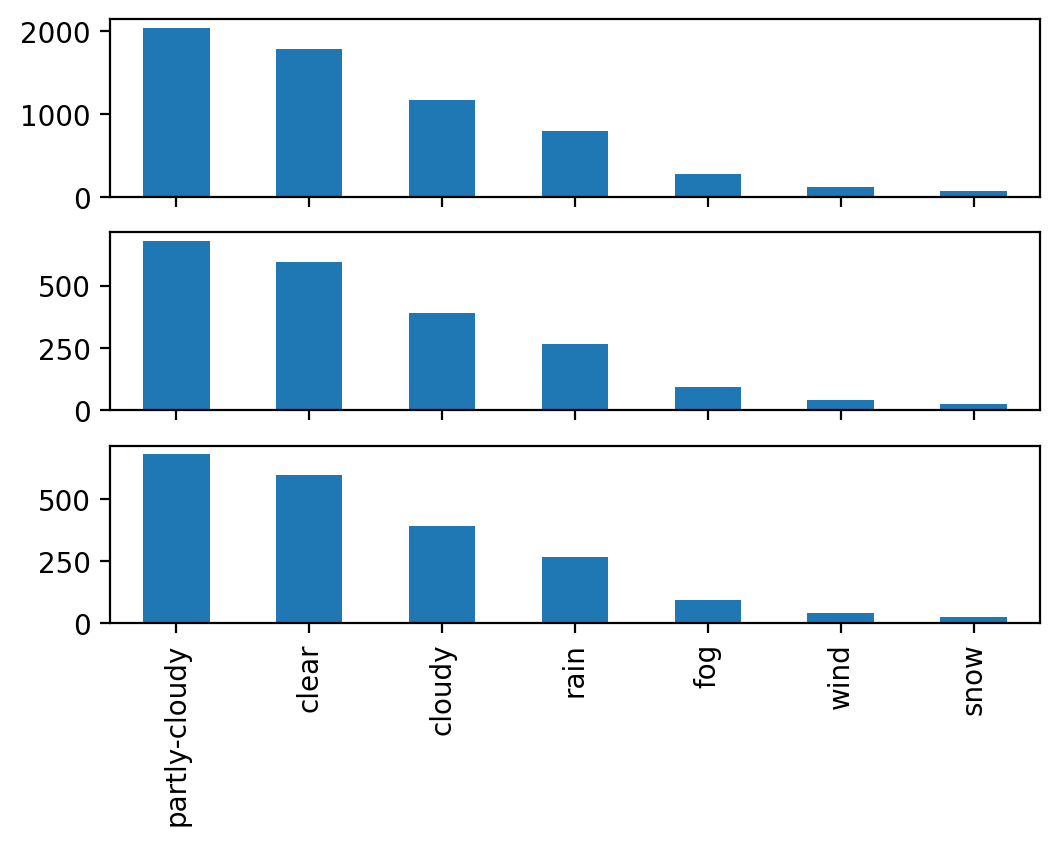

In [30]:
#trực quan hoá dữ liệu 
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
trans_y1 = pd.Series(enc.inverse_transform(y_train))
trans_y1.value_counts().plot(ax=ax1, kind='bar')

trans_y2 = pd.Series(enc.inverse_transform(y_val))
trans_y2.value_counts().plot(ax=ax2,kind='bar');

#ax3 = plt.subplot(3, 1, 3)
trans_y3 = pd.Series(enc.inverse_transform(y_test))
trans_y3.value_counts().plot(ax=ax3,kind='bar');

plt.show()

#### Các cột dữ liệu có dạng gì?

- Dễ thấy các cột dữ liệu phần lớn là kiểu dữ liệu số, chỉ có một số ít các cột là kiểu dữ liệu object.

In [31]:
x_train.dtypes

message                 object
lat                    float64
lng                    float64
time                     int64
summary                 object
temperature            float64
apparentTemperature    float64
dewPoint               float64
humidity               float64
pressure               float64
windSpeed              float64
windGust               float64
windBearing              int64
cloudCover             float64
uvIndex                  int64
visibility             float64
ozone                  float64
Country                 object
dtype: object

#### Các cột dữ liệu dạng số bao gồm các cột nào?

In [32]:
numerical_df = x_train.select_dtypes(exclude='object')
numerical_df.dtypes

lat                    float64
lng                    float64
time                     int64
temperature            float64
apparentTemperature    float64
dewPoint               float64
humidity               float64
pressure               float64
windSpeed              float64
windGust               float64
windBearing              int64
cloudCover             float64
uvIndex                  int64
visibility             float64
ozone                  float64
dtype: object

#### Phân bố dữ liệu trên các cột dữ liệu dạng số như thế nào?

- Ta thực hiện thống kê các giá trị bị thiếu (missing percentage), giá trị trung bình (mean), trung vị (median), yếu vị (lower_quartile), tứ phân vị trên (upper quartile), giá trị lớn nhất (max) nhỏ nhất (min) trên các cột dữ liệu thiếu này

In [33]:
def numerical_distribution(col):
    result = []
    result.append(col.isna().mean() * 100) # missing percpercentage
    result.append(col.min()) # min
    result.append(col.quantile(0.25)) # lower quartile
    result.append(col.median()) # median
    result.append(col.quantile(0.75)) # upper qquartile
    result.append(col.max()) # max
    return pd.Series(result, index=['missing_percentage', 'min','lower_quartile', 'median', 'upper_quartile', 'max'])
    
numerical_df.agg(numerical_distribution).round(1)

,lat,lng,time,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone
missing_percentage,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-38.4,-121.7,1.577866e+09,-66.6,-92.0,-106.7,0.0,957.5,0.7,0.9,0.0,0.0,0.0,0.0,212.1
lower_quartile,9.1,-42.6,1.583914e+09,39.9,35.1,28.1,0.5,1008.5,3.6,5.8,114.0,0.2,0.0,10.0,267.0
median,36.2,19.1,1.592050e+09,58.6,58.6,43.4,0.7,1012.9,6.6,11.0,190.0,0.7,0.0,10.0,286.3
upper_quartile,53.4,105.3,1.601626e+09,74.7,75.7,59.9,0.8,1018.9,10.8,18.7,270.0,1.0,3.0,10.0,325.3
max,71.7,174.8,1.608383e+09,104.9,109.6,81.3,1.0,1067.5,38.5,59.0,359.0,1.0,14.0,10.0,515.2


- Cuối cùng thực hiện trực quan hóa để xem phân phối dữ liệu ở từng cột

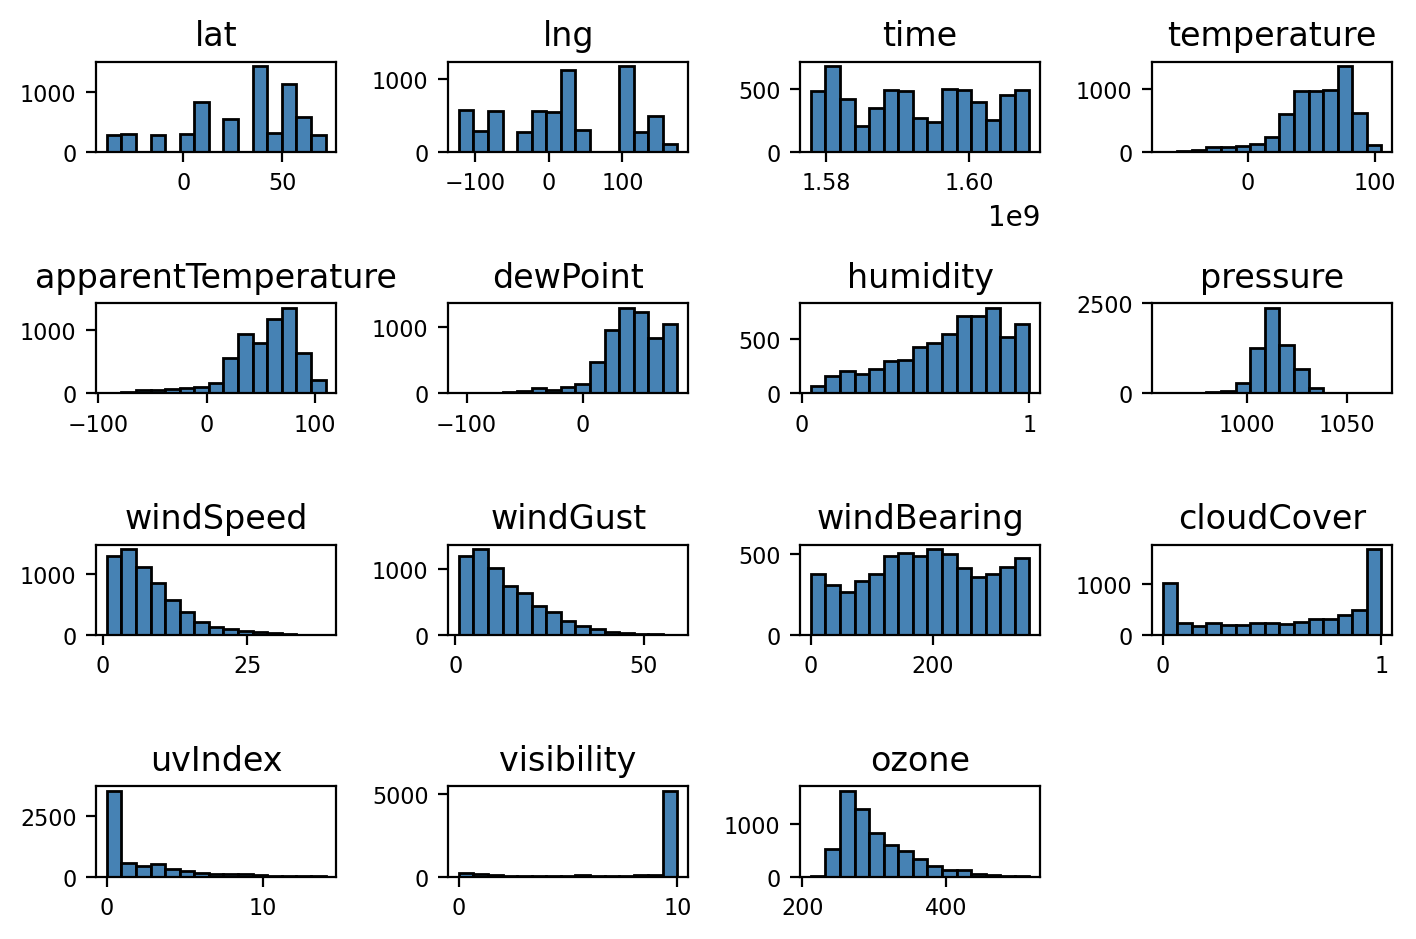

In [34]:
#trực quan hoá dữ liệu
numerical_df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

#### Các cột dữ liệu không phải dạng số bao gồm các cột nào?

In [35]:
categorical_df = x_train.select_dtypes(include='object')
categorical_df.dtypes

message    object
summary    object
Country    object
dtype: object

#### Phân bố dữ liệu trên các cột dữ liệu không phải dạng số như thế nào?

- Dễ thấy cột **message** chỉ biểu thị thông tin dữ liệu thu thập từ API có thành công hay không nên cột này không quan trọng trong quá trình xây dựng mô hình.
- Cột **Country** không thể hiện sự toàn diện trên mô hình, trên thế giới có hơn 200 quốc gia nhưng dữ liệu chúng ta thu thập chỉ có 21 quốc gia, chưa tới 1/10 trên tổng số nên dữ liệu tên quốc gia này sẽ có ý nghĩa cho mô hình nếu ta thu thập tất cả dữ liệu ở tất cả các nước. Nên trong trường hợp này ta sẽ bỏ đi cột này.
- Cột **summary** thì sự giải thích chi tiết không thích hợp cho mô hình, trong khi cột **icon** có giải thích ngắn gọn, xúc tích, thích hợp cho việc làm dữ liệu output cho mô hình, vì vậy ta cũng sẽ bỏ đi cột này ở bước tiếp theo.
- Vậy là ta chỉ còn các cột dữ liệu số trong dataframe.

#### Độ tương quan giữa các thuộc tính số trong dữ liệu

Một trong những cách đơn giản để giảm chiều của dữ liệu (giảm số lượng thuộc tính) là loại bỏ một trong hai cặp thuộc tính tương quan với nhau. Phương pháp này được thực hiện bằng cách tính hệ số tương quan (correlation coeffiency) cho 2 thuộc tính theo công thức:

$r_{A, B}=\frac{\sum_{i=1}^{n}\left(a_{i}-\bar{A}\right)\left(b_{i}-\bar{B}\right)}{n \sigma_{A} \sigma_{B}}=\frac{\sum_{i=1}^{n}\left(a_{i} b_{i}\right)-n \bar{A} \bar{B}}{n \sigma_{A} \sigma_{B}}$

Trong đó:

*   n là số lượng mẫu trong tập dữ liệu.
*   $\sigma_{A}$, $\sigma_{B}$ tương ứng với độ lệch chuẩn của A, B.
*   $a_{i}$, $b_{i}$ tương ứng với các giá trị trong thuộc tính A, B.
*   $\bar{A}$, $\bar{B}$ tương ứng với giá trị trung bình của A, B.

$r_{A,B}$ có giá trị nằm trong khoảng $[-1,1]$:
*  $r_{A,B} > 0$, thuộc tính A, B có quan hệ dương với nhau tức là nếu A tăng thì B tăng. Giá trị $r_{A,B}$ càng lớn thì mức độ phụ thuộc càng cao, suy ra việc loại bỏ A hoặc B sẽ giúp giảm chiều dữ liệu.
*  $r_{A,B} = 0$, thuộc tính A, B không liên quan đến nhau.
* $r_{A,B} < 0$, thuộc tính A, B có quan hệ âm với nhau tức là nếu A tăng thì B giảm và ngược .



In [36]:
def correlation_coeffiency(f_A,f_B):
    return (sum(f_A*f_B)-f_A.size*f_A.mean()*f_B.mean())/(f_A.size*f_A.std()*f_B.std())

Tính hệ số tương quan cho từng cặp thuộc tính trong tập dữ liệu ngoại trừ các thuộc tính như message, lat, lng, time, country, summary và icon không đóng góp vào quá trình phân lớp.

In [37]:
data = data_df.copy(deep=False)
data = data.drop(columns=['message', 'lat', 'lng', 'time','Country',
                          'summary', 'icon'])
column = data.columns
coeff = []
for i in range(len(column)):
    for j in range(len(column)):
        coeff.append(correlation_coeffiency(data[column[i]],data[column[j]]))

##### Trực quan hoá kết quả

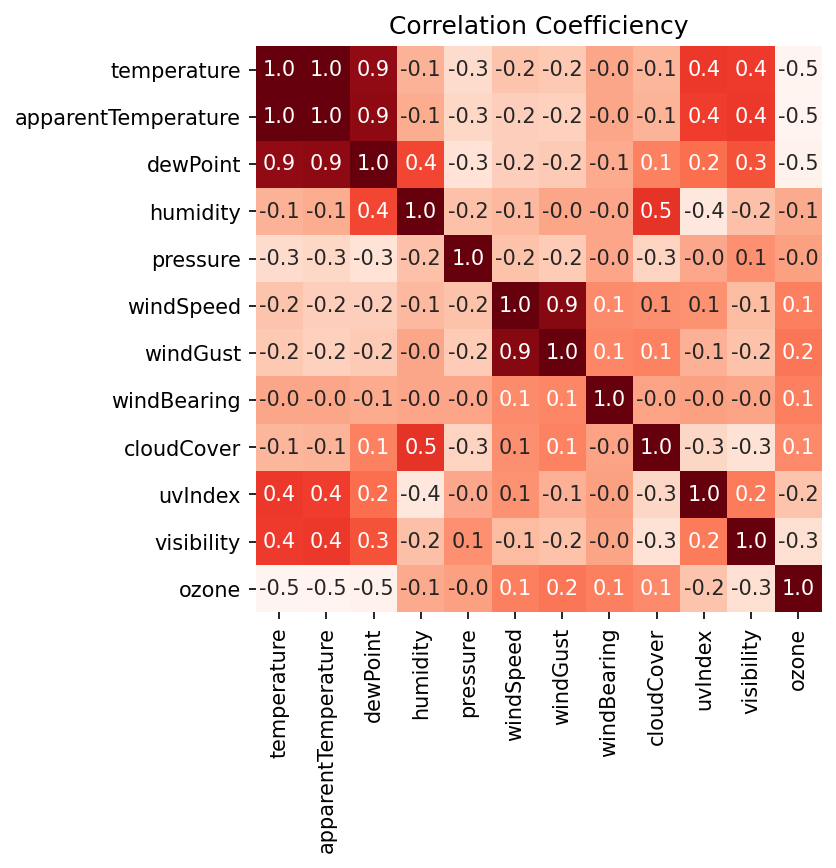

In [38]:
# Trực quan hóa kết quả
plt.rcParams['figure.dpi'] = 150
coeff_df = pd.DataFrame(data=np.array(coeff).reshape(len(column), -1),
                             index=column, columns=column)
min_err = min(coeff)
max_err = max(coeff)
plt.figure(figsize=(10, 5))
#plt.subplot(1, 2, 1)
sns.heatmap(coeff_df, vmin=min_err, vmax=max_err, square=True, 
            annot=True, cbar=False, fmt='.1f', cmap='Reds')
plt.title('Correlation Coefficiency');

**NHẬN XÉT:**

Từ bảng dữ liệu bên trên ta có thể suy ra các cặp thuộc tính có quan hệ dương cao cần loại bỏ:
* temperature và apparentTemperature (1.0).
* temperature và dewPoint (0.9).
* apparentTemperature và dewPoint (0.9).
* windSpeed và windGust (0.9).

Từ các kiến thức liên quan đến thời tiết, ta thấy dữ liệu nhiệt độ rất quan trọng và là nhân tố tiên quyết để quyết định mưa và tuyết. Chính vì vậy ta sẽ bỏ các thuộc tính như sau: apparentTemperature, dewPoint và windGust (do mang tính biến động).

In [39]:
# Thực hiện xoá các dòng dư thừa trên toàn bộ tập dữ liệu X và tập huấn luyện 
# Để khám phá thêm dữ liệu bên dưới
# Việc xoá này sẽ được tích hợp trong pipeline ở bước tiền xử lý bên dưới
deleted_col = ["message","lat","lng","time","Country",
               "summary","apparentTemperature", "dewPoint","windGust"]
deleted_x = X.drop(columns=deleted_col)
deleted_x_train = x_train.drop(columns=deleted_col)

#### Mean Centering and Standardizing
- Lấy các giá trị trung bình của mỗi điểm trừ để loại bỏ độ lệch, sau đó chia cho độ lệch chuẩn.

In [40]:
standard_x_train = (deleted_x_train - deleted_x_train.mean())/ deleted_x_train.std()
standard_x_train.head()

,temperature,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,visibility,ozone
384,-1.079986,-0.540053,1.389254,-0.194139,0.502279,1.063952,-0.641608,0.391734,-0.391895
286,0.685531,1.465803,-0.259359,-0.597057,-0.500713,0.603378,-0.641608,-0.395321,-0.506372
413,0.827430,0.910992,-0.337334,-0.885843,-1.744422,0.738841,-0.641608,0.391734,-0.880044
320,-1.000048,0.313503,-0.259359,-0.195869,-1.533794,1.091044,-0.265945,-3.336339,2.092051
137,-0.636312,-0.070597,0.776594,-0.820131,0.412009,0.847211,-0.641608,0.391734,0.856558


#### Trực quan hoá tập dữ liệu bằng LDA

LDA (Linear Discriminant Analysis) là thuật toán rút trích đặc trưng ẩn của tập dữ liệu với mục tiêu:
* Cực đại hoá khoảng các giữa các phần tử ở hai lớp khác nhau trong tập dữ liệu. Đồng thời cực tiểu hoá khoảng cách giữa các phần tử trong cùng một phân lớp.
* Tìm ra hướng phân lớp tuyến tính sao cho các hướng này phân chia các lớp trong tập dữ liệu một cách tốt nhất.

Phương pháp LDA gồm 2 giai đoạn:
* Giai đoạn 01: Rút gọn số chiều của ảnh nhập với mục tiêu: khoảng cách giữa các mẫu huẩn luyện trong cùng một nhóm gần nhau và khoảng cách giữa các nhóm là lớn
1. Tính ma trận phân tán giữa các nhóm (dựa trên kỳ vọng của từng nhóm): $S_b = \sum_{i=1}^{C}(\mu_i - \mu)(\mu_i-\mu)^T = H_bH_b^T$.
2. Tính ma trận phân tác tích luỹ tương ứng với từng nhóm (dựa vào mẫu huấn luyện): $S_w = \sum_{i=1}^{C}\sum_{j=1}^{M_i}(x_j-\mu_j)(x_j-\mu_j)^T=H_wH_w^T$.
3. Xây dựng hàm tiêu chí tách lớp ($max(H_b)$ và $min(H_w)$): $w = argmax(\frac{trace(G^TS_bG)}{trace(G^TS_wG)})$.
* Giai đoạn 02: Dự đoán nhãn của mẫu dữ liệu nhập (so sánh với vector trung bình của từng nhóm - gần vector trung bình nhất).

In [41]:
#rút gọi còn 2 thuộc tính để dễ trực quan hoá
clf_2 = LDA(n_components=2, priors=None, shrinkage=None, solver='svd', store_covariance=False, tol=0.0001)
X_visual = clf_2.fit_transform(standard_x_train,y_train)
print(X_visual.shape)

(6252, 2)


- Chúng ta xét xem có bao nhiều phần trăm dữ liệu được giữa lại nếu ta lấy 2 thành phần chính bằng phương thực *explained_variance_ratio_* và phương thức *sum* để xem tổng cộng dữ liệu giữ lại của từng thành phần chính.

In [42]:
sum(clf_2.explained_variance_ratio_)

0.9524164174770693

- Dễ thấy có hơn 95% dữ liệu được giữ lại từ 2 thành phần trên. Sau đây ta sẽ trực quan thử để xem phân bố của các điểm dữ liệu như thế nào.

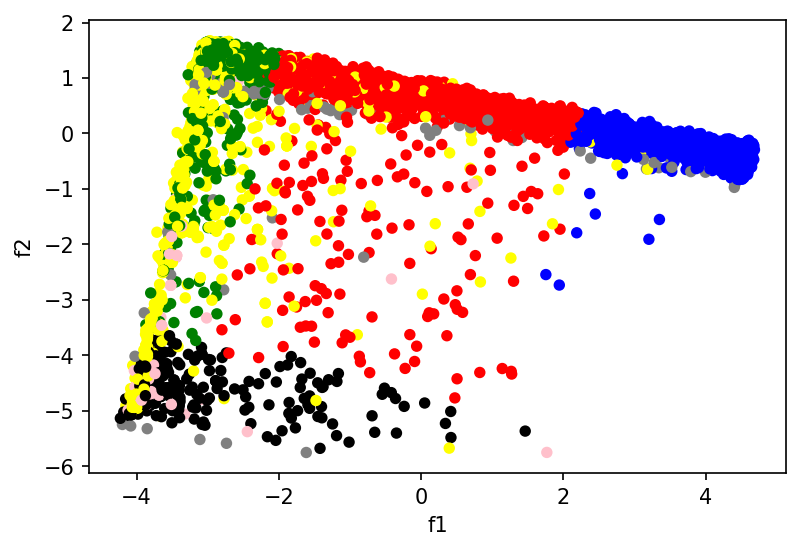

In [43]:
data_visual = pd.DataFrame(X_visual,columns=["f1","f2"])
data_visual.insert(2, "icon", enc.inverse_transform(y_train))#y_tmp))
colors = {'partly-cloudy':'red', 'cloudy':'green', 'clear':'blue', 'rain':'yellow',\
          "fog":"black", "wind":"grey", "snow":"pink"}
data_visual.plot.scatter(x="f1",y="f2",c=data_visual["icon"].map(colors))
plt.show()

**Nhận xét:**

Các điểm dữ liệu trong không gian mới các lớp **đỏ, xanh dương** đã phân biệt khác rõ ràng nhưng ở các lớp còn lại vẫn còn chồng lấn các điểm dữ liệu với nhau.Do đó khi tăng số lượng chiều lên có thể dữ liệu sẽ phân biệt tốt hơn và ta sẽ tìm không gian này bằng cách tự động của mô hình LDA của scikit-learn. Do số lượng chiều quá lớn nên ta không thể trực quan được.

### Tiền xử lí (trên tập dữ liệu huấn luyện)

### Tái tạo mẫu

#### Mô tả tổng quan các phương pháp tái tạo mẫu 

**Các phương pháp cơ bản:**
*  Undersampling: xoá mẫu phổ biến.
	- Tính toán K mẫu phổ biến và từ K mẫu đó chọn ngẫu nhiên mẫu để xoá. 
	- Vấn đề: Xoá mất đi dữ liệu quan trọng và giảm tỉ lệ biểu diễn.
* Oversampling: tăng mẫu thiểu số.
	- Chọn bất kỳ mẫu dữ và thêm vào tập dữ liệu cho đến khi nào đạt trạng thái cân bằng.
	- Vấn đề: có thể dẫn đến tình trạng quá khớp dữ liệu.


**SMOTE algorithm:**
*   Dựa trên ý tưởng tạo ra một số lượng nhất định mẫu nhân tạo gần giống với lớp thiểu số.  Tìm độ dị biệt giữa các thuộc tính của a và b (a là láng giềng của b) là d. Sau đó nhân d cho một số bất kỳ có giá trị từ 0 đến 1 ta được d'. Lấy d' cộng với các thuộc tính của a ta được một mẫu mới.
* Vấn đề 01: do bỏ qua các mẫu phổ biến nên có thể dẫn tới vấn đề các lớp không hoàn toàn tách biệt nhau. Ví dụ nếu mẫu của một lớp khác nằm giữa mẫu mục tiêu và mẫu láng giềng thì mẫu mới được tạo ra có xu hướng gần với mẫu của một lớp khác.
* Vấn đề 02: Do siêu tham số k mẫu gần nhất phải được chọn từ đầu sẽ làm giảm khả năng cân bằng và linh hoạt của phương pháp này.
* Vượt trội hơn các phương pháp truyền thống ở chỗ thay vì chỉ dùng lại các mẫu có sẵn thì phương pháp này sẽ tạo ra mẫu mới gần giống với các mẫu trong cùng một lớp.


**ADASYN:** Dựa trên thuật toán tổng hợp mẫu nhân tạo và cho phép tái tạo thích nghi số lượng mẫu khác nhau dữ trên phân bố của chúng.
* Dữ liệu đầu vào: m mẫu với các giá trị ${x_i,y_i}$ với $x_i$ là các thuộc tính của mẫu và $y_i$ là nhãn tương ứng với từng mẫu.
* Kết quả đầu ra: tập dữ liệu sau khi được cân bằng.
* Thuật toán:
1.   Tính toán tỉ lệ phân lớp $d = \frac{m_r}{m_x}$ với $m_r$ là số lượng mẫu cực tiểu và $m_x$ là số lượng mẫu cực đại.
2.   Nếu $d < d_x$ ($d_x$ là siêu tham số dùng để giới hạn tỉ lệ cân bằng mẫu) thì thực hiện tiếp bước 3 và ngược lại thì kết thúc thuật toán.
3. Tìm số lượng mẫu cần tái tạo: $G = (m_x-m_r)\times \beta$ với $\beta$ là siêu tham số cân bằng ($\beta = 1$, cân bằng hoàn toàn giữa tập thiểu số và tập phổ biến).
4. Tìm K láng giềng gần nhất của từng mẫu trong tập thiểu số bằng khoảng cách Eucide (các láng giềng này có thể không thuộc tập thiểu số) và tính $r = \frac{\Delta_i}{K}$ với $\Delta_i$ là số phần tử láng giềng không thuộc lớp thiểu số.
5. Chuẩn hoá $r_x = \frac{r_i}{\sum_{j=1}^Kr_j}$ thành phân bố mật độ.
6. Tính toán số mẫu nhân tạo cho từng mẫu trong tập thiểu số: $g_i = r_x \times G$.
7. Tái tạo $g_i$ mẫu cho từng mẫu $x_i$ trong tập thiểu số bằng cách chọn ngẫu nhiên từ các mẫu láng giềng ($x_{zi}$) của $x_i$ (thuộc lớp thiểu số). Mẫu mới được tạo ra theo công thức: $s_i = x_i + (x_{zi}) + x_i)\times \alpha$  với $\alpha$ có giá trị từ 0 đến 1.


  
  Tài liệu tham khảo: On methods for improving the accuracy
of multi-class classification on imbalanced data. Tác giả: Leonid A. Sevastianova, Eugene Yu. Shchetininb. Năm:2020

In [44]:
ada = ADASYN(sampling_strategy='minority',n_neighbors=5)
temp_x = deleted_x_train
temp_y = y_train
for i in range(5):
    temp_x,temp_y = ada.fit_resample(temp_x, temp_y)

In [45]:
print(temp_x.shape)

(14072, 9)


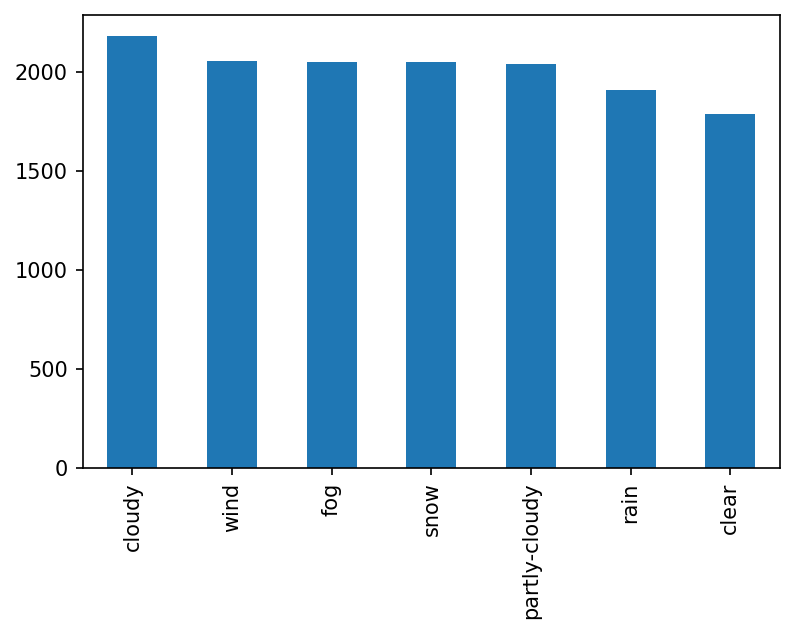

In [46]:
#y_res.value_counts().plot(ax=ax3,kind='bar');
truth_label = enc.inverse_transform(temp_y)
series = pd.Series(truth_label) 
series.value_counts().plot(kind='bar');

#### Xoá các thuộc tính và tiền xử lý


* Loại bỏ các một trong 2 thuộc tính có quan hệ dương trong các cặp vừa liệt kê ở trên (chọn loại bỏ apparentTemperature, dewPoint và windGust) và đồng thời loại bỏ các thuộc tính không tham gia vào việc phân lớp dữ liệu như message, lat, lng, time, country, summary. 
* Chuẩn hoá dữ liệu bằng cách lấy các giá trị trung bình của mỗi điểm trừ để loại bỏ độ lệch, sau đó chia cho độ lệch chuẩn.

In [47]:
class ColPreprocess(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X_df, y=None):
        all_cols = X_df.columns.to_list()
        self.columns = [i for i in all_cols if i not in deleted_col]
        return self
    def transform(self, X_df, y=None):
        tmp_df = X_df.copy(deep=False)
        for i in deleted_col:
            if i in tmp_df.columns.to_list():
                tmp_df = tmp_df.drop(i, axis=1)
        return tmp_df

#### Thử nghiệm class ColPreprocess trên tập train

In [48]:
colpreprocess = ColPreprocess()
colpreprocess.fit(x_train)
colpreprocess.transform(x_train)

,temperature,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,visibility,ozone
384,26.61,0.53,1026.0,6.91,238,0.98,0,10.000,282.5
286,72.77,1.00,1011.2,4.58,138,0.81,0,7.964,277.2
413,76.48,0.87,1010.5,2.91,14,0.86,0,10.000,259.9
320,28.70,0.73,1011.2,6.90,35,0.99,1,0.356,397.5
137,38.21,0.64,1020.5,3.29,229,0.90,0,10.000,340.3
...,...,...,...,...,...,...,...,...,...
424,74.89,0.90,1012.6,2.36,91,0.97,1,10.000,268.6
287,37.34,0.69,1005.9,15.58,287,0.95,0,7.595,412.6
366,43.27,0.77,1001.5,3.40,317,0.98,0,10.000,288.1
30,58.69,0.33,1008.9,9.30,346,0.00,0,10.000,286.5


#### Xây dựng lớp chuẩn hóa cho dữ liệu đầu vào

In [49]:
all_cols = X.columns.to_list()
data_cols =[i for i in all_cols if i not in deleted_col]  
data_trans = StandardScaler()
col_tras = ColumnTransformer(transformers =[                                      
    ('standard', data_trans, data_cols)],
     remainder='passthrough')

## Xây dựng mô hình

### Mô hình Multi Layer Perceptron

Mô hình Multi Layer Perceptron có thể hiểu đơn giản là một chuỗi các mô hình perceptron kết hợp lại với nhau để dự đoán kết quả đầu ra Y dựa vào dữ liệu đầu vào X. Mô hình này là sự kết hợp của các hàm tuyến tính nhằm học được biểu diễn phi tuyến của tập dữ liệu.

Các bước trong MLP:
* Mô hình MLP trải qua L lớp hay còn được gọi là lớp ẩn với mỗi lớp ẩn sẽ tương ứng với số lượng nơ ron được định nghĩa trước - có thể hiểu mỗi nơ ron trong mỗi lớp tương ứng với trọng số cần học. 

* Sau khi được huấn luyện qua L lớp, hàm kích hoạt (activation function) được sử dụng như bộ phận tổng hợp các kết quả đầu ra ở lớp ẩn cuối cùng sao cho có dạng giống tập dữ liệu nhãn Y.

* Sử dụng các mô hình tối ưu để tối ưu hoá các trọng số trong mô hình MLP bằng backpropagation.

Lợi ích của MLP: 
* Có khả nặng học được các biểu diễn phi tuyến.
* Có khả năng học được mô hình trong thời gian thực.

Rào cản của MLP:
* Mô hình không thể hội tụ nếu trong tập dữ liệu có nhiều hơn một cực trị cục bộ và với trọng số khởi tạo khác nhau sẽ cho giá trị khác nhau.
* Mô hình này yêu cầu nhiều giá trị siêu tham số như số lớp ẩn, số nơ ron của lớp ẩn, số vòng lặp.
* Nhạy cảm với việc mở rộng các đặc trưng.

Các tham số được sử dụng trong mô hình MLP:
* Lớp ẩn: 20
* Hàm kích hoạt: ReLU (Rectified Linear Unit)
  - Công thức: $f(s) = max(0,s)$
  - Được sử dụng nhiều bởi vì tính đơn giản giúp tiết kiệm thời gian trong quá trình backprogation và hạn chế mất mát.
  - Giúp mô hình hội tụ nhanh hơn.
* Mô hình tối ưu: 
  - SGD (Stochastic Gradient Descent): Cập nhật giá trị trọng số N lần tương ứng với N điểm dữ liệu trong một epoch. Kết quả sau khi chạy SGD hội tụ theo đường zip zac nhanh hơn so với các thuật toán khác nhưng chỉ hiệu quả trên tập dữ liệu đủ lớn.
  - LBFGS (Limited-memory Broyden Fletcher Goldfarb Shanno): Thuật toán dựa trên thuật toán Quasi-Newton (trọng số trong mô hình được cập nhật bằng gradient và ma trận Hess). Tuy nhiên, chi phí tính ma trận Hess cho mỗi trọng số là quá lớn nên sẽ được thay thế bằng một hàm ước lượng cập nhật được nghiên cứu bởi Broyden, Fletcher, Goldfarb và Shanno: 
$\mathbf{H}_{n+1}^{-1}=\left(I-\rho_{n} y_{n} s_{n}^{T}\right) \mathbf{H}_{n}^{-1}\left(I-\rho_{n} s_{n} y_{n}^{T}\right)+\rho_{n} s_{n} s_{n}^{T}$ trong đó $s_n$ hiệu kết quả input và $y_n$ là hiệu gradient của phần tử trước đó. Mô hình này được dùng nhiều trong các trường hợp có dữ liệu ít vì hội tụ nhanh hơn và cho kết quả tốt hơn.[(Giải thích chi tiết)](https://aria42.com/blog/2014/12/understanding-lbfgs)

$\Rightarrow$ Do dữ liệu trong đồ án lần này không nhiều, nên nhóm quyết định dùng mô hình tối ưu LBFGS để cập nhật các trọng số một các hiệu quả hơn cho mô hình xây dựng.

In [50]:
preprocess = ColPreprocess()
lda_model = LDA( priors=None, shrinkage=None, solver='svd', store_covariance=False, tol=0.0001)
nn_model = MLPClassifier(hidden_layer_sizes=(20), activation='relu', solver='lbfgs', random_state=0, max_iter=2500)
mlp_pipeline = make_pipeline(preprocess,col_tras,lda_model, nn_model)
#print(mlp_pipeline.get_params())
mlp_pipeline

Pipeline(steps=[('colpreprocess', ColPreprocess()),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard', StandardScaler(),
                                                  ['temperature', 'humidity',
                                                   'pressure', 'windSpeed',
                                                   'windBearing', 'cloudCover',
                                                   'uvIndex', 'visibility',
                                                   'ozone'])])),
                ('lineardiscriminantanalysis', LinearDiscriminantAnalysis()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=20, max_iter=2500,
                               random_state=0, solver='lbfgs'))])

### Mô hình Support Vector Classification



Support Vector Machine là mô hình tách lớp dựa trên các vector hỗ trợ từ tập huấn luyện ($w = \sum_{i\in SV}\alpha_iy_ix_i$). Mô hình này thường được dùng cho các bài toán phân tách hai lớp sao cho khoảng cách gần nhau nhất của hai điểm thuộc hai lớp là xa nhau nhất có thể. 

Các bước chạy của mô hình:
1. Chọn hàm kernel K.
2. Chọn giá trị điều khiển biến trượt để tránh tình trạng quá khớp dữ liệu trên tập huấn luyện: C.
3. Bài toán tối ưu hoá bậc hai để tìm tham số cho các vector hỗ trợ: $w = \sum_{i\in SV}\alpha_iy_ix_i$.
4. Xây dựng hàm tách lớp từ các vector hỗ trợ: $g(x) = \sum_{i \in SV}\alpha_ix_i^Tx+b$.

Ưu điểm:
* Cho kết quả tốt khi có sự rạch ròi rõ ràng giữa các lớp.
* Mô hình cho hiệu quả cao trong không gian nhiều chiều.
* Hiệu quả trong trường hợp số chiều nhiều hơn số phân lớp.
* Mô hình SVM quản lý bộ nhớ hiệu quả.
* Một ưu điểm đặc biệt mà nhóm quyết định chọn mô hình SVM để thử nghiệm đó là do mô hình này có hỗ trợ cập nhật trọng số $w$ dựa trên số lượng của từng phân lớp (cost sensitivity).


Nhược điểm:
* Mô hình SVM không thích hợp đối với các dự án có khối lượng dữ liệu lớn.
* Cho kết quả không tốt khi dữ liệu của mô hình bị nhiễu hay các lớp bị trùng lắp nhau.
* Không thể mô hình hoá các tập dữ liệu có số thuộc tính nhiều hơn số lượng mẫu.


Các tham số trong mô hình SVM:
* Hàm kernel:
  - Linear: Hàm tuyến tính với $K(x_i,x_j)=x_i^Tx_j$.
  - Poly: Hàm mũ với $K(x_i,x_j) = (1+x_i^Tx_j)^p$.
  - Rbf: Hàm phân phối Guassian với $K(x_i,x_j)=exp(-\frac{||x_i-x_j||^2}{2\sigma^2})$.
  - Sigmoid: Hàm phi tuyến với $K(x_i,x_j)=tanh(\beta_0x_i^Tx_j+\beta_1)$.
* Tham số class_weight: Như đã nói ban đầu tập dữ liệu phân bố không đều ở các lớp và có khả năng gây ra tình trạng chỉ phân lớp đúng ở các mẫu phổ biến và đa phần cho kết quả sai ở các mẫu thiểu số. Chính vì vậy, ta sẽ dùng tham số "balanced" để cân bằng mức độ quan trọng giữa các lớp khi cập nhật trọng số $w$ trong quá trình học theo công thức: $weight = \frac{nsamples}{nclasses * np.bincount(y)}$

Do tập dữ liệu là đa lớp nên mô hình SVC trong trường hợp này sử dụng phương pháp One-vs-one để phân loại các mẫu. One-vs-one là chiến lược tách nhỏ các mẫu dữ liệu thành các mô hình phân loại 2 lớp và lớp có giá trị dự đoán cao nhất trong các bộ phân lớp thì sẽ được lấy làm kết quả dự đoán. Số lượng mô hình phân lớp đôi được tính theo công thức: $classifiers = \frac{NumClass \times (NumClass -1)}{2}$. Trong trường hợp này thì ta có được số lượng bộ phân lớp được tạo ra là $\frac{7 \times (7-1)}{2} = 21$

In [51]:
svc_model = SVC(kernel = "rbf",class_weight='balanced', # penalizekernel='poly’', 
            probability=True)
svc_pipeline = make_pipeline(preprocess,col_tras,lda_model, svc_model)
#print(svc_pipeline.get_params())
svc_pipeline

Pipeline(steps=[('colpreprocess', ColPreprocess()),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard', StandardScaler(),
                                                  ['temperature', 'humidity',
                                                   'pressure', 'windSpeed',
                                                   'windBearing', 'cloudCover',
                                                   'uvIndex', 'visibility',
                                                   'ozone'])])),
                ('lineardiscriminantanalysis', LinearDiscriminantAnalysis()),
                ('svc', SVC(class_weight='balanced', probability=True))])

## Thử nghiệm mô hình

### Mô hình Multi Layer Perceptron

#### Thử nghiệm trên tập huấn luyện ban đầu



In [52]:
train_errs = []
val_errs = []
alpha_arr = [0.1, 1, 10, 100]
best_val_err = float('inf')
best_alpha = None
for alpha in alpha_arr:
    mlp_pipeline.set_params(mlpclassifier__alpha= alpha)
    mlp_pipeline.fit(x_train, y_train)
    train_predicts = mlp_pipeline.predict(x_train)
    train_error = (train_predicts != y_train).sum() / len(train_predicts) *100
    train_errs.append(train_error)
    
    val_predicts = mlp_pipeline.predict(x_val)
    val_error = (val_predicts != y_val).sum() / len(val_predicts) * 100
    val_errs.append(val_error)
    
    if val_error <= min(val_errs):
        best_val_err = val_error
        best_alpha = alpha

'Finish!'

C:\Users\USER\anaconda3\envs\min_ds-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


'Finish!'

In [53]:
#xét trên tập validation 
print("Độ lỗi tốt nhất: ",best_val_err)
print("Giá trị alpha tốt nhất: ",best_alpha)

Độ lỗi tốt nhất:  10.93525179856115
Giá trị alpha tốt nhất:  1


In [54]:
#Dự đoán trên tập dữ liệu
mlp_pipeline.set_params(mlpclassifier__alpha= alpha)
mlp_pipeline.fit(x_train, y_train)
test_predicts = mlp_pipeline.predict(x_test)
test_error = (test_predicts != y_test).sum() / len(test_predicts) * 100
print("Độ lỗi trên tập kiểm tra: ",test_error)

Độ lỗi trên tập kiểm tra:  12.470023980815348


In [55]:
#visualize the error rate of each class
def visual(test,pred):
    set_1 = pd.Series(test[pred != test]).value_counts()
    set_2 = pd.Series(test).value_counts()
    result ={}
    for i in set_2.index:
        if i not in set_1.index:
            result[i]=0
        else:
            result[i]=set_1[i]/set_2[i]*100
    names = list(result.keys())
    values = list(result.values())
    plt.bar(range(len(result)), values, tick_label=enc.inverse_transform(names))
    plt.show()

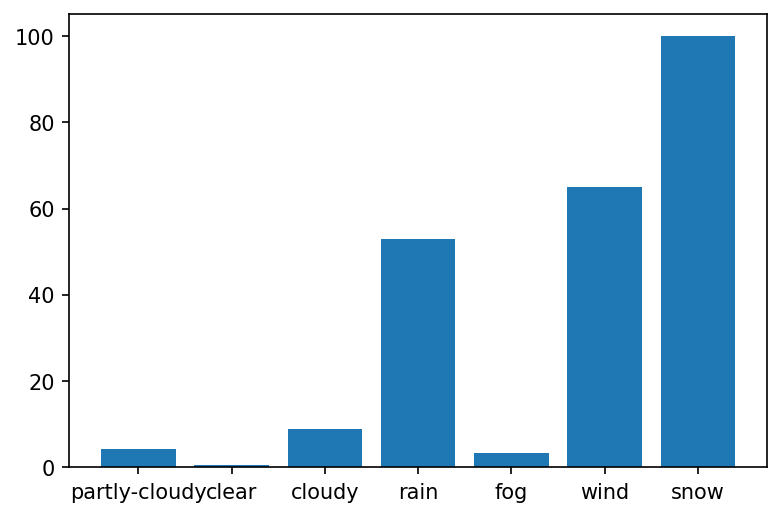

In [56]:
visual(y_test,test_predicts)

**Nhận xét:**

Từ biểu đồ trên ta có thể thấy, dù độ lỗi trên tập test chỉ 10% (độ chính xác gần 89.6%) nhưng lại cho kết quả sai rất cao đối với các mẫu thuộc tập thiểu số như snow (sai gần 99%), wind (sai hơn 80%) và rain (sai gần 60%). Điều này xảy ra do việc mất cân bằng dữ liệu, số lượng dữ liệu ở tập partly-cloudy, clear và cloudy quá lớn dẫn tới việc thống trị hoàn toàn độ lỗi của mô hình trong lúc học.

#### Thử nghiệm trên tập tái tạo mẫu

In [57]:
ba_train_errs = []
ba_val_errs = []
alpha_arr = [0.1, 1, 10, 100]
ba_best_val_err = float('inf')
ba_best_alpha = None
ba_best_componentVal = None
balanced_train_x = pd.DataFrame(temp_x,columns=['temperature', 'humidity', 'pressure', 'windSpeed', 'windBearing',
       'cloudCover', 'uvIndex', 'visibility', 'ozone'])
balanced_train_y = pd.Series(temp_y)
for alpha in alpha_arr:
  #for n_components in component_arr:
    mlp_pipeline.set_params(mlpclassifier__alpha= alpha)
    mlp_pipeline.fit(balanced_train_x, balanced_train_y)
    train_predicts = mlp_pipeline.predict(balanced_train_x)
    train_error = (train_predicts != balanced_train_y).sum() / len(train_predicts) *100
    ba_train_errs.append(train_error)
    
    val_predicts = mlp_pipeline.predict(x_val)
    val_error = (val_predicts != y_val).sum() / len(val_predicts) * 100
    ba_val_errs.append(val_error)
    
    if val_error <= min(ba_val_errs):
        ba_best_val_err = val_error
        ba_best_alpha = alpha

'Finish!'

C:\Users\USER\anaconda3\envs\min_ds-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\USER\anaconda3\envs\min_ds-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


'Finish!'

In [58]:
#xét trên tập validation 
print("Độ lỗi tốt nhất: ",ba_best_val_err)
print("Giá trị alpha tốt nhất: ",ba_best_alpha)

Độ lỗi tốt nhất:  14.388489208633093
Giá trị alpha tốt nhất:  10


In [59]:
#Dự đoán trên tập dữ liệu
balanced_train_x = pd.DataFrame(temp_x,columns=['temperature', 'humidity', 'pressure', 'windSpeed', 'windBearing',
      'cloudCover', 'uvIndex', 'visibility', 'ozone'])
balanced_train_y = pd.Series(temp_y)
mlp_pipeline.set_params(mlpclassifier__alpha= alpha)
mlp_pipeline.fit(balanced_train_x, balanced_train_y)
test_predicts = mlp_pipeline.predict(x_test)
test_error = (test_predicts != y_test).sum() / len(test_predicts) * 100
print("Độ lỗi trên tập kiểm tra: ",test_error)

Độ lỗi trên tập kiểm tra:  16.30695443645084


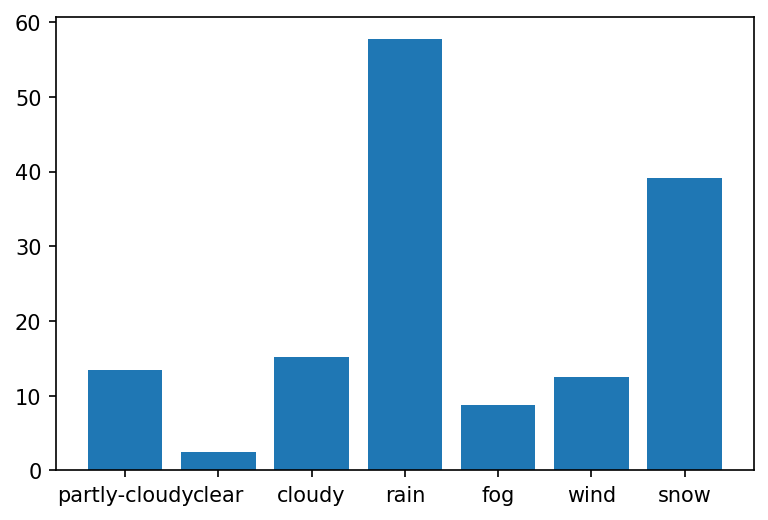

In [60]:
#trực quan hoá 
visual(y_test,test_predicts)

**Nhận xét:**

Mô hình MLP được áp dụng trên tập dữ liệu đã được tái tạo mẫu cho kết quả thấp hơn tập dữ liệu ban đầu khoảng 5% nhưng ta có thể thấy việc phân lớp sai các mẫu thiểu số đã có sự cải thiện rõ rệt: snow (giảm từ 99% xuống hơn 70%), wind (giảm từ hơn 80% xuống hơn 10%), rain (giảm từ 60% xuống còn 50%). Chủ yếu độ lỗi tăng lên là do phân lớp sai các mẫu phổ biến ở các lớp như partly-cloud, clear, cloudy nhưng việc sai sót đối với các mẫu phổ biến này là có thể chấp nhận được. Đặt trường hợp mô hình cần dự đoán thời tiết hiện tại để người dùng có thể chuẩn bị dụng cụ phù hợp (ủng, dù, áo khoác) thì việc dự đoán sai thời tiết bình thường thành các kiểu thời tiết bất thường khác không mấy quan trọng bằng việc phân lớp sai các tập bất thường.

### Mô hình Support Vector Classification

In [61]:
#‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
train_errs = []
val_errs = []
kernel_arr = ["linear", "poly", "rbf", "sigmoid"]
best_val_err = float('inf')
best_kernel = None
for kernel in kernel_arr:
    svc_pipeline.set_params(svc__kernel = kernel)
    svc_pipeline.fit(x_train, y_train)
    train_predicts = svc_pipeline.predict(x_train)
    train_error = (train_predicts != y_train).sum() / len(train_predicts) *100
    train_errs.append(train_error)
    
    val_predicts = svc_pipeline.predict(x_val)
    val_error = (val_predicts != y_val).sum() / len(val_predicts) * 100
    val_errs.append(val_error)
    
    if val_error <= min(val_errs):
        best_val_err = val_error
        best_kernel = kernel

'Finish!'

'Finish!'

In [62]:
#xét trên tập validation 
print("Độ lỗi tốt nhất: ",best_val_err)
print("Kernel cho kết quả tốt nhất: ",best_kernel)

Độ lỗi tốt nhất:  13.621103117505996
Kernel cho kết quả tốt nhất:  poly


In [63]:
#xét trên tập test
svc_pipeline.set_params(svc__kernel = best_kernel)
svc_pipeline.fit(x_train, y_train)
test_predicts = svc_pipeline.predict(x_test)
test_error = (test_predicts != y_test).sum() / len(test_predicts) * 100
print("Độ lỗi trên tập kiểm tra: ",test_error)

Độ lỗi trên tập kiểm tra:  13.42925659472422


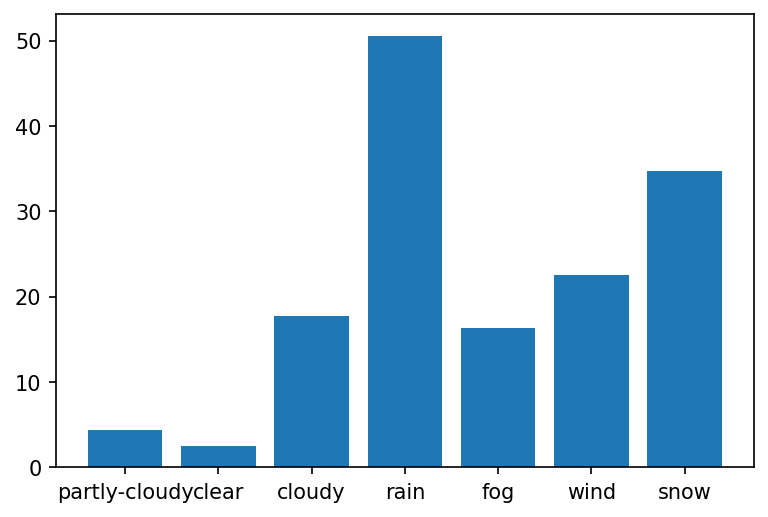

In [64]:
#trực quan hoá 
visual(y_test,test_predicts)

**Nhận xét:**

Việc đánh trọng số cân bằng lên trọng số trong quá trình học cho kết quả tương tự đối với phương pháp sử dụng MLP lên tập dữ liệu tái tạo. Tuy nhiên trong mô hình SVM lại cho kết quả sai trong lớp snow thấp hơn rất nhiều với tập tái tạo mẫu cụ thể ở đây là 30%.

## Ý tưởng cải tiến

Có thể thấy dù mô hình cho độ lỗi khá thấp nhưng đối với các mẫu thiểu số thì độ lỗi vẫn nằm ở ngưỡng rất cao. Nhóm nhận thấy do dữ liệu hiện tại nhóm thu thập không nhiều nên không thể sử dụng các phương pháp "state-of-the-art" (do các mô hình này thường khá phức tạp và chỉ thích hợp đối với các tập dữ liệu lớn). Chính vì vậy, nếu có thời gian tiếp tục cải tiến, nhóm sẽ tập trung vào việc thu thập dữ liệu và xây dựng một mô hình phức tạp hơn để xử lý việc mất cân bằng dữ liệu trong đa phân lớp.